<a href="https://colab.research.google.com/github/markgrmek/fenics_lift_and_drag/blob/main/NSE_Lift_Drag.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Installation of FEniCS in Colab via
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

In [ ]:
from fenics import *
from mshr import *
from google.colab import drive

In [ ]:
parameters["std_out_all_processes"] = False;

DEFINING THE DOMAIN AND FUNCTION SPACES

In [ ]:
#DEFINING THE DOMAIN

L_domain  = 23.0 #lenght of the domain
H_domain  = 12.0 #height of the domain
X_disc  = 6.0 #position of the centre of the disc along the x-axis
Y_disc = H_domain/2
r_disc  = 2.0 #radius of the disc
resolution_disc = 200 #4*16 #number of fragrments

rectangle_domain   = Polygon([Point(0,0),Point(L_domain,0),Point(L_domain,H_domain),Point(0,H_domain)])
disc   = Circle(Point(X_disc,Y_disc),r_disc,resolution_disc)
domain = rectangle_domain - disc
mesh   = generate_mesh(domain,32) #integer value presents mesh refinment


In [ ]:
# Define function spaces (P2-P1)
velocity_function_space = VectorFunctionSpace(mesh, "Lagrange", 2)  #velocity (2d vector)
pressure_function_space = FunctionSpace(mesh, "Lagrange", 1) #pressure (scalar)

DEFINING THE BOUNDARIES AND BOUNDARY CONDITIONS

In [ ]:
# Define boundary markers
boundary_markers = MeshFunction("size_t", mesh, mesh.topology().dim() - 1)
boundary_markers.set_all(0)
ds = ds(subdomain_data=boundary_markers)

class TopBottomBoundary(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and (near(x[1], 0, DOLFIN_EPS) or near(x[1], H_domain, DOLFIN_EPS))

class LeftBoundary(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], 0, DOLFIN_EPS)

class OutflowBoundary(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], L_domain, DOLFIN_EPS)

class DiscBoundary(SubDomain):
    def inside(self, x, on_boundary):
        disc_x_left = X_disc - r_disc
        disc_x_right = X_disc + r_disc
        disc_y_bottom = Y_disc - r_disc
        disc_y_top = Y_disc + r_disc
        return on_boundary and (disc_x_left < x[0] < disc_x_right and disc_y_bottom < x[1] < disc_y_top)

top_bottom_boundary = TopBottomBoundary()
left_boundary = LeftBoundary()
outflow_boundary = OutflowBoundary()
disc_boundary = DiscBoundary()

top_bottom_boundary.mark(boundary_markers, 1)
left_boundary.mark(boundary_markers, 2)
outflow_boundary.mark(boundary_markers, 3)
disc_boundary.mark(boundary_markers, 4)

In [ ]:
#DEFINE BOUNDARY CONDITIONS
flow_velocity = 0.5

#velocity boundary conditions
u_inflow = Constant((flow_velocity, 0.0))
u_top_bottom = Constant((flow_velocity, 0.0))
u_zero = Constant((0.0, 0.0))

top_bottom_boundary_conditions = DirichletBC(velocity_function_space, u_top_bottom, top_bottom_boundary)
left_boundary_conditions = DirichletBC(velocity_function_space, u_inflow, left_boundary)
disc_boundary_conditions = DirichletBC(velocity_function_space, u_zero, disc_boundary)
velocity_boundary_conditions  = [top_bottom_boundary_conditions, left_boundary_conditions, disc_boundary_conditions]


#pressure boundary conditions
p_outflow = Constant((0.0))

bco = DirichletBC(pressure_function_space, p_outflow, outflow_boundary)
pressure_boundary_conditions = [bco]

DEFINING THE SOLVER

In [ ]:
#DEFINE TRIAL AND TEST FUNCTIONS
u_trial = TrialFunction(velocity_function_space)
v_test = TestFunction(velocity_function_space)

p_trial = TrialFunction(pressure_function_space)
q_test = TestFunction(pressure_function_space)

#DEFINE SOLUTION FIELDS
u_prev = Function(velocity_function_space) #velocity in previous step
u_next = Function(velocity_function_space)  #velocity in next step
p_next = Function(pressure_function_space) #pressure in next time step

#OTHER PARAMETERS
#U = 0.5*(u_prev + u_next)
facet_normal = FacetNormal(mesh)
f = Constant((0,0))

#FLUID PARAMETERS
density = Constant(1)
dynamic_viscosity = Constant(0.01)
kinematic_viscosity = Constant(dynamic_viscosity/density)

In [ ]:
#SIMULATION PARAMETERS
total_simulation_time = 100
dt = 0.01
#dt = Constant(dt)

In [ ]:
#WEAK FORM OF THE MOMENTUM EQUATION
#dx means we integrate over entire domain - inbuilt function
#DEFINING VARIATIONAL PROBLEM FOR 1 STEP
F1 = (density/dt)*inner(u_trial - u_prev, v_test)*dx + inner(grad(u_prev)*u_prev, v_test)*dx + kinematic_viscosity*inner(grad(u_trial), grad(v_test))*dx - inner(f, v_test)*dx
a1 = lhs(F1)
L1 = rhs(F1)

#DEFINING VARIATIONAL PROBLEM FOR 2 STEP
a2 = inner(grad(p_trial), grad(q_test))*dx
L2 = - (density/dt)*div(u_next)*q_test*dx

#DEFINING VARIATIONAL PROBLEM FOR 3 STEP
a3 = inner(u_trial, v_test)*dx
L3 = dot(u_next, v_test)*dx - dt*inner(nabla_grad(p_next), v_test) * dx

In [ ]:
# ASSEMBLE THE MATRICES
A1 = assemble(a1)
A2 = assemble(a2)
A3 = assemble(a3)

#APPLY BOUNDARY CONDITIONS
[bound_cond.apply(A1) for bound_cond in velocity_boundary_conditions]
[bound_cond.apply(A2) for bound_cond in pressure_boundary_conditions]

[None]

RUNNING THE SIMULATION

In [ ]:
drive.mount('/content/drive')
drive_path = '/content/drive/output/'
u_file = File(f"{drive_path}velocity_output.pvd", "compressed")
p_file = File(f"{drive_path}pressure_output.pvd", "compressed")

In [ ]:
#Run simulation
    # Use amg preconditioner if available
prec = "amg" if has_krylov_solver_preconditioner("amg") else "ilu"


lift = []
drag = []
time_step = dt
while time_step < total_simulation_time:

  if time_step%10==0:
    print ("t=" +str(time_step))

  #update boundary cond
  p_outflow.t = dt

  # COMPUTE TENTATIVE VELOCITY STEP
  b1 = assemble(L1)
  [bound_cond.apply(A1, b1) for bound_cond in velocity_boundary_conditions]
  solve(A1, u_next.vector(),b1,"gmres",'default')

  # COMPUTE PRESSURE CORRECTION STEP
  b2 = assemble(L2)
  [bound_cond.apply(A2, b2) for bound_cond in pressure_boundary_conditions]
  solve(A2, p_next.vector(), b2, "cg", prec)

  # COMPUTE VELOCITY CORRECTION STEP
  b3 = assemble(L3)
  solve(A3, u_next.vector(), b3, "gmres", "default")

  #CALCULATING THE CAUHY STRESS TENSOR
  # σ=−pI+2μϵ where  ϵ = 1/2*(grad(u) + grad(u).T) == symetric part of the tensor

  I = Identity(u_next.geometric_dimension())
  cauchy_stress = dot(-p_next*I + 2.0*dynamic_viscosity*sym(grad(u_next)), facet_normal)

  # INTEGRATING OVER THE ENTIRE DOMAIN
  drag_force = assemble(cauchy_stress[0]*ds(4))
  lift_force = assemble(cauchy_stress[1]*ds(4))

  lift.append(lift_force)
  drag.append(drag_force)

  u_next.rename("u", "velocity")
  p_next.rename("p", "pressure")
  u_file << u_next
  p_file << p_next

  #ASSIGN NEW VALUES
  u_prev.assign(u_next)

  time_step += dt


QUICK VISUALIZE OF THE RESULTS

In [ ]:
plot(u_next, title = "Velocity", rescale = True)

NameError: ignored

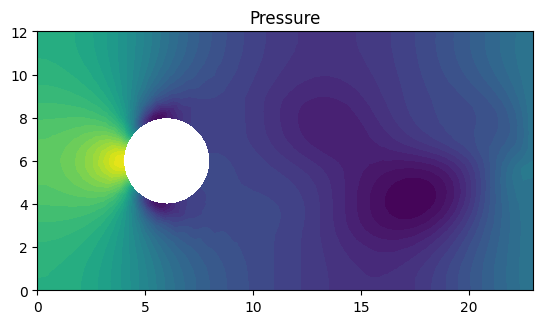

In [ ]:
plot(p_next, title="Pressure", rescale=True)


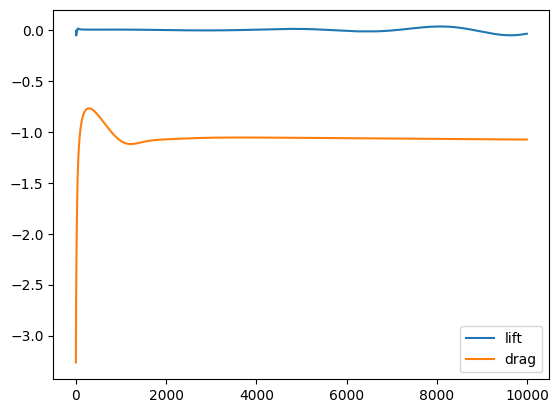

In [ ]:
import matplotlib.pyplot as plt
plt.plot(lift[5:], label = "lift")
plt.plot(drag[5:], label = "drag")
plt.legend(loc = "lower right")